# Hybrid Data type CNN - Regression

This is a generic notebook to handle hybrid type data. By hybrid type data, we mean data where each data point has both structured features and an image. For example, A data set might contain a person's physical measurements, as well as a photo of their face. The response variable might be how attractive they are from 0 to 1. 

## Importing Core Libraries

In [31]:
import tensorflow as tf
print(tf.__version__)
#I used tensorflow version 2.3.3

2.3.3


In [32]:
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6109187894238733593
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16740968887557702340
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5860481012838333517
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14676252416
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8030963071800696467
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [34]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

# should be a non-empty list if you program recognizes the GPU

['/device:GPU:0']

## Importing the Data

Your dataset should be in a format such that you have one column with the filenames of the images, one column with the response variable, and the rest of your columns should be your features.

In [35]:
#fill in this section for your dataset

dataset_filename = "test_dataset.csv"

response_col_name = "resp"

image_filename_col_name = "images"

path = "Images" #the path where your iamges are stored. You may leave this as an empty string if your dataset contains full paths for your images. 

In [ ]:
df = pd.read_csv(dataset_filename)
df.head(5)

In [37]:
df.shape

(94102, 70)

In [38]:
response = df[response_col_name]
image_filenames = df[image_filename_col_name]

features_df = df.drop([response_col_name, image_filename_col_name], axis = 1)

In [39]:
features_df.shape

(94102, 68)

## Preprocessing

Here we will preprocess the data. By default, we will encode and scale the data. Feel free to add your own steps.

In [40]:
#one-hot encoding
print(features_df.shape)
features_df = pd.get_dummies(features_df)
print(features_df.shape)

(94102, 68)
(94102, 111)


In [41]:
#normal scaling
normalized_df=(features_df-features_df.mean())/features_df.std()

In [ ]:
# add back the image filenames
normalized_df[image_filename_col_name] = image_filenames
normalized_df.head()

## Data Generator

Because we may be using a large dataset, there is a chance that loading our entire dataset into memory may not be feasible. For image problems we can get around this the tensorflow class ImageDataGenerator. However, since we are using hybrid data, we also would need a generator for the non-image feature data. These would need to be wrapped up in another generator and that generator would be passed to the model for training. I tried this approach, but found lots of issues with shuffling, images getting out of order, and weird edge cases. In the end I decided to build my own generator that alliviated all these problems. It runs slower than the tensorflow solution, but I found the performance loss to be negligible when compared to the computational load of training the model. 

In [159]:
import numpy as np
from matplotlib import image
def CustomGenerator(path, features_with_images_df, response_series, batch_size, im_width = image_width, im_height = image_height, im_channels = image_channels):
    response = response_series.to_numpy()
    
    size = len(response)
    
    def GetImage(filename):
        return image.imread( path + filename)[:,:,:im_channels]
    
    def GetManyImages(filenames):
        arr = np.zeros((batch_size, im_width, im_height, im_channels))
        for j, filename in enumerate(filenames):
            arr[j] = GetImage(filename)
        return arr
    
    features_without_images = features_with_images_df.drop(image_filename_col_name, axis = 1).to_numpy()
    image_filenames = features_with_images_df[image_filename_col_name]
    i = 0
    
    while True:
            resp = response[i:i + batch_size]
            features = features_without_images[i:i + batch_size, :]
            images = GetManyImages(image_filenames[i:i + batch_size])
            #print("i:",i)
            yield ((features, images), resp)
            i += batch_size
            
            if i >= size:
                i = 0
                #print('restart')

## Model Definition

Here we will be defining our hybrid CNN - MLP model. The images are fed through a CNN, whilst the non-image feature data is fed through an MLP. The outputs of each are combined into another MLP. Below you will need to define your hyper parameters.

In [160]:
from keras.models import Sequential
from keras.layers.core import Dense

def create_mlp(dim, regularizer=None):
    """Creates a simple two-layer MLP with inputs of the given dimension. You can change these dimension or add more layers."""
    model = Sequential()
    model.add(Dense(32, input_dim=dim, activation="relu", kernel_regularizer=regularizer))
    model.add(Dropout(0.25))
    model.add(Dense(16, activation="relu", kernel_regularizer=regularizer))
    model.add(Dense(network_outputs, activation="relu", kernel_regularizer=regularizer))
    return model

In [161]:
from keras.layers import Flatten, Input, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Dropout, Dense
from keras.layers.normalization import BatchNormalization
from keras.models import Model

def create_cnn(width, height, depth, filters=(16, 32, 64), regularizer=None):
    """
    Creates a CNN with the given input dimension and filter numbers.
    """
    # Initialize the input shape and channel dimension, where the number of channels is the last dimension
    inputShape = (height, width, depth)
    chanDim = -1
 
    # Define the model input
    inputs = Input(shape=inputShape)
 
    # Loop over the number of filters 
    for (i, f) in enumerate(filters):
        # If this is the first CONV layer then set the input appropriately
        if i == 0:
            x = inputs
 
        # Create loops of CONV => RELU => BN => POOL layers
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        
    # Final layers - flatten the volume, then Fully-Connected => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16, kernel_regularizer=regularizer)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.3)(x)
 
    # Apply another fully-connected layer, this one to match the number of nodes coming out of the MLP
    x = Dense(network_outputs, kernel_regularizer=regularizer)(x)
    
    #You may need to modify this for your type of problem:
    
    #Classification
    #x = Activation("softmax")(x)
    
    #Regression
    x = Activation("relu")(x)
    
    
 
    # Construct the CNN
    model = Model(inputs, x)
 
    # Return the CNN
    return model

In [1]:
#this function plots the results
def plot_results(history):
    met = history.history[loss_metric]
    epochs = range(1, len(met) + 1)
    
    for m in metrics:
        met = history.history[m]
        met_val = history.history["val_"+m]
        plt.plot(epochs, met, 'g.', label='Training')
        plt.plot(epochs, met_val, 'g', label='Validation')
        plt.title(m)
        plt.figure()            
        plt.legend()
        
    plt.show()
    

## Creating the Model

Here we create a model using our model definition functions

In [195]:
from keras.regularizers import l1
from keras.regularizers import l2
from keras.models import Sequential
from keras.optimizers import Adam # Other optimisers are available

In [196]:
reg = None #l1(0.01) you may want to use regularizer to help reduce overfitting

In [197]:
#The regression metric your model will try to optimize. Only this metric will affect the training. 
#use another metric for classification
loss_metric = 'mean_squared_error' 

metrics = [loss_metric, 'mean_absolute_error'] #The metrics your model will calculate during training. You can add other metrics to this list, but they will not affect the training. 

filters = (16, 32, 64) #each number here will increase the size of your CNN. The number represents the depth at that layer. 

image_width = 200  #the width of your image in pixels
image_height = 200  #the height of your image in pixels
image_channels = 3 #the number of color channels in your image (3 for RGB, 4 for RGBA)

network_outputs = 8 #the number outputs both the MLP and CNN have. (They don't need to be the same, you can change them each individually)

learning_rate = 1e-3

save_path = "Models/run1" #the name of your model's save path. you may have to create a Models folder. Change this to avoid overwriting models you have already trained. 

In [177]:
# Create the MLP and CNN models
mlp = create_mlp(normalized_df.shape[1] - 1, reg) #take 1, because we are going to remove the image paths in the generator
cnn = create_cnn(image_width, image_height, image_channels, filters, reg)
 
# Create the input to the final set of layers as the output of both the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])

x = Dense(network_outputs, activation="relu")(combinedInput)
x = Dropout(0.3)(x)
x = Dense(16, activation="relu")(x)

#last layer should have something like relu for regression
x = Dense(1, activation="relu")(x)

#We are using a relu activation on the last layer for regression. Depending on your response data, you may need to use a different activation function. 
#For example, relu will not handle negative numbers

In [178]:
# Rerun this cell to reset the model

# The final model accepts numerical data on the MLP input and images on the CNN input, outputting a single value

model_main = Model(inputs=[mlp.input, cnn.input], outputs=x)

# Compile the model 
opt = Adam(lr=learning_rate, decay=learning_rate / 200)

model_main.compile(loss=loss_metric, metrics=metrics, optimizer=opt)

## Callbacks

These callbacks are used to help the model. If you change your model, make sure you double check these. For example, if you use r2, you will need to set mode to max

In [179]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(mode = 'min', monitor = 'val_loss', patience = 3)

In [180]:
from tensorflow.keras.callbacks import ModelCheckpoint
savePath = save_path
checkpoint = ModelCheckpoint(savePath)

## Creating the Data Generators

Here we will create the data generators for both the training and validation sets.

In [181]:
# How many batches are used for each calculation. 
batch_size = 32 

#The proportion of the total dataset used for training. The rest will be used for validation. 
train_size = 0.8

In [182]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(normalized_df, response, train_size = train_size)

In [183]:
#This process may remove some data points at the end due to rounding, never more than the batch size. 

extra_train = len(y_train)%batch_size
extra_test = len(y_test)%batch_size

X_train = X_train[:-extra_train]
y_train = y_train[:-extra_train]

X_test = X_test[:-extra_test]
y_test = y_test[:-extra_test]

In [184]:
print(len(y_test)%batch_size)
print(len(y_train)%batch_size)

# both numbers should be 0, otherwise your model may encounter an error at the end of its first epoch. 
# this is caused because the dataset may not always go evenly into the batch size. 
# The data generator should account for this, but it hasn't been fully tested. 

0
0


In [185]:
#Here we create the generators from the data set. 
gen =    CustomGenerator(path, X_train,  y_train, batch_size)
genVal = CustomGenerator(path, X_test,   y_test,  batch_size)

## Training the Model

If you training the model, it will continue from the where it left off unless you reset the model by reset the model_main variable

In [189]:
#The number of times the training algorithm will go through the entire dataset.
epochs = 5

In [190]:
model_history = model_main.fit(
  x = gen,  
  epochs = epochs, 
  steps_per_epoch = len(y_train)//batch_size,
  verbose = 1,  
  validation_data = genVal,
  validation_batch_size = batch_size,
  validation_steps = len(y_test)/batch_size,
  callbacks = [es, checkpoint],
)

Epoch 1/5
2352/2352 [==============================] - 131s 56ms/step - loss: 1.3135 - mean_squared_error: 1.3135 - mean_absolute_error: 0.2016 - val_loss: 1.1662 - val_mean_squared_error: 1.1662 - val_mean_absolute_error: 0.1915
Epoch 2/5
2352/2352 [==============================] - 130s 55ms/step - loss: 1.3135 - mean_squared_error: 1.3135 - mean_absolute_error: 0.2016 - val_loss: 1.1662 - val_mean_squared_error: 1.1662 - val_mean_absolute_error: 0.1915
Epoch 3/5
2352/2352 [==============================] - 127s 54ms/step - loss: 1.3135 - mean_squared_error: 1.3135 - mean_absolute_error: 0.2016 - val_loss: 1.1662 - val_mean_squared_error: 1.1662 - val_mean_absolute_error: 0.1915
Epoch 4/5
2352/2352 [==============================] - 128s 54ms/step - loss: 1.3135 - mean_squared_error: 1.3135 - mean_absolute_error: 0.2016 - val_loss: 1.1662 - val_mean_squared_error: 1.1662 - val_mean_absolute_error: 0.1915


## Plotting the Data

No handles with labels found to put in legend.
No handles with labels found to put in legend.


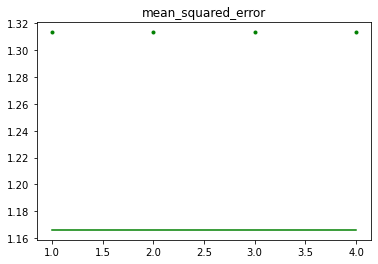

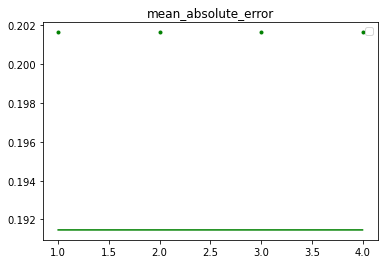

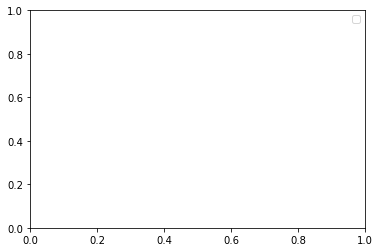

In [208]:
plot_results(model_history)

In [193]:
genVal = CustomGenerator(path, X_test,   y_test,  batch_size)

In [ ]:
#run this many times to see predictions. 
x,y = next(genVal)
preds = model_main.predict(x)
df_results = pd.DataFrame({'Actual':y,'Preds':preds[:,0]})
df_results['Difference'] = df_results['Actual'] - df_results['Preds']

In [ ]:
df_results